# Recomendation Systems and Deep Learning

*Implementing recommedation systems on movie dataset using different approaches and at the end using deep learning.*

---

**Dataset Used:** MovieLens Dataset of 1 Million ratings for nearly 3,900 Movies by around 6,000 Users. This dataset was selected because it has the feature with which we can use different reccomendation methods on it.


---


**Methods Implemented:** Content-Based Filtering, Collaborative Filtering, Model Based Filtering, Model based on Deep Learning

In [ ]:
# Libraries
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape, Dropout, Activation, Lambda
from keras.models import Model, Sequential
from keras.layers import dot, concatenate
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

# Implementation

Firstly, load data

In [ ]:
# Reading ratings file
# Ignore the timestamp column
rs_ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])

# Reading users file
rs_users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
rs_movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

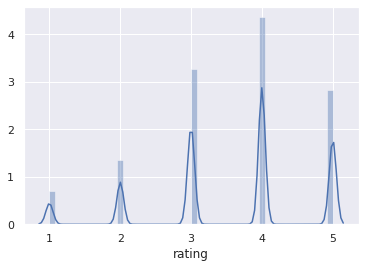

In [ ]:
# Ratings Distribution
sns.set_style('whitegrid')
sns.set(font_scale=1)
%matplotlib inline

# Display distribution of rating
sns.distplot(rs_ratings['rating'].fillna(rs_ratings['rating'].mean()))

In [ ]:
# Creating single dataframe
dataset = pd.merge(pd.merge(rs_movies, rs_ratings),rs_users)
# Top 10 movies.
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(10)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,"Simple Plan, A (1998)",Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


## Content-Based Filtering

We will be using TF-IDF that is Term Frequency-Inverse Document Frequency.

TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

 **tfidf(t, d, D) = tf(t, d) * idf(t, D)**

Where **tf(t,d)** is Term Frequency, the variant used is a raw count of the occurence of the word t in d.

And **idf(t, D)** is Inverse Document Frequency the variant used is log scaled fraction of the total number of documents by the number of documents containing the term. 

This calculation will help find the relative importance of movies.

In the next part Vector Space Model is used to find the relevence ranking of movies based on genres. Vector Space Model basically by finding angle between the vectors we can find which movies are closely related to each other, the lesser the angle more similar the movies are to each other. We will use Cosine Similarity will be used it is basically the dot product of the vectors. Larger the Cosine value More Similar the movies are.


In [ ]:
# Split the genre column 
rs_movies['genres'] = rs_movies['genres'].str.split('|')
rs_movies['genres'] = rs_movies['genres'].fillna("").astype('str')

rs_tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
rs_tfidf_matrix = rs_tf.fit_transform(rs_movies['genres'])

# Cosine Similarity using dot product of vectors
rs_cosine_sim = linear_kernel(rs_tfidf_matrix, rs_tfidf_matrix)

In [ ]:
titles = rs_movies['title']
indices = pd.Series(rs_movies.index, index=rs_movies['title'])

def rs_recommendFunction(title):
    idx = indices[title]
    sim_scores = list(enumerate(rs_cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
# Top 10 recommendation for movie: The Matrix
rs_recommendFunction('American Beauty (1999)').head(10)

44                              To Die For (1995)
71                   Kicking and Screaming (1995)
74                               Big Bully (1996)
83             Last Summer in the Hamptons (1995)
104    Nobody Loves Me (Keiner liebt mich) (1994)
131                              Nueba Yol (1995)
164                   Doom Generation, The (1995)
203                        Unstrung Heroes (1995)
216                       Boys on the Side (1995)
229                    Eat Drink Man Woman (1994)
Name: title, dtype: object

The Content-Based Filtering approach doesn't face the cold start problem and the long tail problem as it doesn't need other users data and not so popular movies will also show up in recommendations based on similarity

But the main disadvantages would be that it would not take into account other users and will be restricted to the users own profile.

# Memory-Based Collaborative Filtering

1) User-User Collaborative Filtering

2) Item-Item Collaborative Filtering

In [ ]:
# Fill NaN values in user_id and movie_id column with 0
rs_ratings['user_id'] = rs_ratings['user_id'].fillna(0)
rs_ratings['movie_id'] = rs_ratings['movie_id'].fillna(0)

# Replace NaN values in rating column with average of all values
rs_ratings['rating'] = rs_ratings['rating'].fillna(rs_ratings['rating'].mean())

# Using 2% of Data because of limited computing power
data_fraction = rs_ratings.sample(frac=0.02)

# Spliting data into 80 to 20 ratio.
train_data, test_data = train_test_split(data_fraction, test_size=0.2)

train_data = np.array(train_data)
test_data =  np.array(test_data)
# Check their shape
print(data_fraction.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 240216 to 88367
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   20004 non-null  int64
 1   movie_id  20004 non-null  int64
 2   rating    20004 non-null  int64
dtypes: int64(3)
memory usage: 625.1 KB
None


In [ ]:
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.80704222 0.88245059 0.98444584]
 [0.80704222 1.         0.98994615 0.89823221]
 [0.88245059 0.98994615 1.         0.9513695 ]
 [0.98444584 0.89823221 0.9513695  1.        ]]


In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.02035466  0.00706306]
 [-0.02035466  1.         -0.05931685]
 [ 0.00706306 -0.05931685  1.        ]]


In [ ]:
# Prediction function for Memory-based Collaborative Filtering
def mem_colab_predict(ratings, similarity, type='user-user'):
    if type == 'user-user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item-item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [ ]:
# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    mse = mean_squared_error(pred, actual)
    rmse = sqrt(mse)
    return rmse

In [ ]:
# Predict ratings on the training data with both similarity score
user_colab_predict = mem_colab_predict(train_data, user_correlation, type='user-user')
item_colab_predict = mem_colab_predict(train_data, item_correlation, type='item-item')

In [ ]:
# RMSE on the test data

print('User-based CF RMSE: ' + str(rmse(user_colab_predict, test_data)))
print('Item-based CF RMSE: ' + str(rmse(item_colab_predict, test_data)))

User-based CF RMSE: 1424.2761079337524
Item-based CF RMSE: 1648.7069650061228


In [ ]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_colab_predict, train_data)))
print('Item-based CF RMSE: ' + str(rmse(item_colab_predict, train_data)))

User-based CF RMSE: 698.6082123333912
Item-based CF RMSE: 155.42085866512022


The Memory-Based Collaborative Filtering approach is easier in implementation and deployment.

But the main disadvantages would be that it would not solve the cold start problem. another problem is difficulty with sparse data and propensity towards popular movies.

Problems with this approach is that this method doesn't scale well with larger datasets and the recommendations given to the users are not very good as we can see the root mean squared error is quite large

# Model-Based Collaborative Filtering

Method: Matrix Factorization

We will use Singular Vector Decomposition which is a dimensionality reduction technique.

First Lets Load the data again

In [ ]:
# Reading ratings file
svd_rs_ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
svd_rs_users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
svd_rs_movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

n_users = svd_rs_ratings.user_id.unique().shape[0]
n_movies = svd_rs_ratings.movie_id.unique().shape[0]
print('Number of users = ',str(n_users),'\nNumber of movies = ',str(n_movies))

Number of users =  6040 
Number of movies =  3706


In [ ]:
new_ratings = svd_rs_ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
new_ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


De-Normalize data after normalization by mean of each users

In [ ]:
R = np.array(new_ratings)
user_ratings_mean = np.mean(R, axis = 1)
denorm_ratings = R - user_ratings_mean.reshape(-1, 1)

In [ ]:
sparsity = round(1.0 - len(svd_rs_ratings) / float(n_users * n_movies), 3)
print('The sparsity of dataset is ',str(sparsity * 100))

The sparsity of dataset is  95.5


Singular Vector Decompostion with scipy as it has manual latent factor value.

The svd function will decompose the matrix to three matrices.

In [ ]:
U, sigma, Vt = svds(denorm_ratings, k = 50)

# Change sigma values to a diagonal matrix
sigma = np.diag(sigma)

In [ ]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds = pd.DataFrame(predicted_ratings, columns = new_ratings.columns)

In [ ]:
def svd_recommendations(predictions, userID, movies, user_ratings, num_movies):
    
    row_number = userID - 1
    sorted_user_predictions = preds.iloc[row_number].sort_values(ascending=False) # User ID starts at 1
    
    data = user_ratings[user_ratings.user_id == (userID)]
    full_data = (data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').sort_values(['rating'], ascending=False))

    print('Movies rated by user {0}:'.format(userID), full_data.shape[0])

    # Recommendations by highest predicted ratings.
    predictions = (movies[~movies['movie_id'].isin(full_data['movie_id'])].merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',left_on = 'movie_id',right_on = 'movie_id').rename(columns = {row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_movies, :-1])

    return full_data, predictions

In [ ]:
previous_ratings, predictions = svd_recommendations(preds, 999, svd_rs_movies, svd_rs_ratings, 10)

Movies rated by user 999: 412


In [ ]:
previous_ratings.head(10)

,user_id,movie_id,rating,timestamp,title,genres
290,999,3386,5,975363490,JFK (1991),Drama|Mystery
184,999,805,5,975363780,"Time to Kill, A (1996)",Drama
48,999,2411,5,975046875,Rocky IV (1985),Action|Drama
382,999,1213,5,975048027,GoodFellas (1990),Crime|Drama
381,999,3753,5,975044156,"Patriot, The (2000)",Action|Drama|War
380,999,1210,5,975043866,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
293,999,318,5,975047680,"Shawshank Redemption, The (1994)",Drama
30,999,919,5,975363017,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
110,999,2641,5,975045995,Superman II (1980),Action|Adventure|Sci-Fi
186,999,1196,5,975042787,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War


In [ ]:
print(predictions)

      movie_id                            title                   genres
1928      2268           Few Good Men, A (1992)              Crime|Drama
312        377                     Speed (1994)  Action|Romance|Thriller
359        434               Cliffhanger (1993)   Action|Adventure|Crime
394        480             Jurassic Park (1993)  Action|Adventure|Sci-Fi
2667      3082  World Is Not Enough, The (1999)          Action|Thriller
124        150                 Apollo 13 (1995)                    Drama
2120      2490                   Payback (1999)          Action|Thriller
1699      2023  Godfather: Part III, The (1990)       Action|Crime|Drama
405        494        Executive Decision (1996)          Action|Thriller
665        786                    Eraser (1996)          Action|Thriller


Intresting Observation here would be that even though movie genres were not explicitly, our model still recognized the implicit factor in the recommendation

# Deep Learning Implementation

Sequential Model from Keras is used.


In [ ]:
dl_ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
dl_total_user = dl_ratings['user_id'].drop_duplicates().max()
dl_total_movies = dl_ratings['movie_id'].drop_duplicates().max()

dl_users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

dl_movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [ ]:
shuffled_dl_ratings = dl_ratings.sample(frac=1., random_state=1)
new_users = shuffled_dl_ratings['user_emb_id'].values
print(new_users, ', shape =', new_users.shape)

new_movies = shuffled_dl_ratings['movie_emb_id'].values
print(new_movies, ', shape =', new_movies.shape)

new_ratings = shuffled_dl_ratings['rating'].values
print(new_ratings, ', shape =', new_ratings.shape)

[3808 1388 4509 ... 2898 3024  827] , shape = (1000209,)
[2923 1956 1478 ... 2663 1295 1380] , shape = (1000209,)
[4 4 2 ... 4 5 2] , shape = (1000209,)


A Shallow Model

In [ ]:
# Deep Learning Model Architecture.
n_users = dl_total_user
m_items = dl_total_movies
k_factors = 100

P = Sequential()
P.add(Embedding(n_users, k_factors, input_length=1))
P.add(Reshape((k_factors,)))
Q = Sequential()
Q.add(Embedding(m_items, k_factors, input_length=1))
Q.add(Reshape((k_factors,)))

merged_output = dot([P.output, Q.output], axes=1)
output_model = Sequential()
opt = optimizers.Adamax()
model = Model(input=[P.input, Q.input], output=output_model(merged_output))
model.compile(loss='mse', optimizer=opt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("se...)`
  from ipykernel import kernelapp as app


In [ ]:
callbacks = [EarlyStopping('val_loss', patience=2), ModelCheckpoint('weights.h5', save_best_only=True)]

# Using 30 epochs, 90% training data, 10% validation data 
history = model.fit([new_users, new_movies], new_ratings, epochs=30, validation_split=.1, verbose=2, callbacks=callbacks)

Train on 900188 samples, validate on 100021 samples
Epoch 1/30
 - 200s - loss: 0.8971 - val_loss: 0.8795
Epoch 2/30
 - 210s - loss: 0.8469 - val_loss: 0.8489
Epoch 3/30
 - 207s - loss: 0.8161 - val_loss: 0.8269
Epoch 4/30
 - 207s - loss: 0.7922 - val_loss: 0.8116
Epoch 5/30
 - 208s - loss: 0.7712 - val_loss: 0.7978
Epoch 6/30
 - 200s - loss: 0.7512 - val_loss: 0.7885
Epoch 7/30
 - 201s - loss: 0.7313 - val_loss: 0.7790
Epoch 8/30
 - 202s - loss: 0.7116 - val_loss: 0.7694
Epoch 9/30
 - 198s - loss: 0.6915 - val_loss: 0.7626
Epoch 10/30
 - 193s - loss: 0.6710 - val_loss: 0.7588
Epoch 11/30
 - 189s - loss: 0.6502 - val_loss: 0.7543
Epoch 12/30
 - 189s - loss: 0.6293 - val_loss: 0.7519
Epoch 13/30
 - 188s - loss: 0.6082 - val_loss: 0.7486
Epoch 14/30
 - 188s - loss: 0.5873 - val_loss: 0.7502
Epoch 15/30
 - 188s - loss: 0.5667 - val_loss: 0.7493


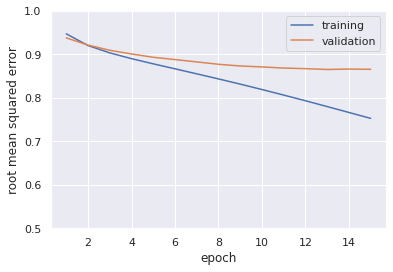

In [ ]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ sqrt(loss) for loss in history.history['val_loss'] ]})
ax = loss.iloc[:,:].plot(x='epoch')
ax.set_ylabel("root mean squared error")
ax.set_ylim([0.5,1.0]);

In [ ]:
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(sqrt(min_val_loss)))

Minimum RMSE at epoch 13 = 0.8652


In [ ]:
# Use the pre-trained model
trained_model = model
# Load weights
trained_model.load_weights('weights.h5')
# Pick a random test user
dl_users[dl_users['user_id'] == 777]

,user_id,gender,zipcode,age_desc,occ_desc
776,777,M,87543,18-24,unemployed


In [ ]:
# Prediction function Deep Learning
def predict_rating(user_id, movie_id):
    return trained_model.predict([np.array([user_id-1]), np.array([movie_id-1])])[0][0]

In [ ]:
# Top rated movies by user 777
dl_user_ratings = dl_ratings[dl_ratings['user_id'] == 777][['user_id', 'movie_id', 'rating']]
dl_user_ratings['prediction'] = dl_user_ratings.apply(lambda x: predict_rating(777, x['movie_id']), axis=1)
dl_user_ratings.sort_values(by='rating', ascending=False).merge(dl_movies, on='movie_id', how='inner', suffixes=['_u', '_m']).head(10)

,user_id,movie_id,rating,prediction,title,genres
0,777,2571,5,3.865253,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,777,246,5,2.586853,Hoop Dreams (1994),Documentary
2,777,356,5,3.640148,Forrest Gump (1994),Comedy|Romance|War
3,777,3793,5,3.349792,X-Men (2000),Action|Sci-Fi
4,777,1909,4,3.002199,"X-Files: Fight the Future, The (1998)",Mystery|Sci-Fi|Thriller
5,777,1196,4,3.773934,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
6,777,1198,4,3.570285,Raiders of the Lost Ark (1981),Action|Adventure
7,777,316,4,2.788357,Stargate (1994),Action|Adventure|Sci-Fi
8,777,1356,4,2.700914,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi
9,777,527,4,3.783901,Schindler's List (1993),Drama|War


In [ ]:
# Top 10 recommendations for user 777
dl_recommendations = dl_ratings[dl_ratings['movie_id'].isin(dl_user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
dl_recommendations['prediction'] = dl_recommendations.apply(lambda x: predict_rating(777, x['movie_id']), axis=1)
dl_recommendations.sort_values(by='prediction',ascending=False).merge(dl_movies,on='movie_id',how='inner',suffixes=['_u', '_m']).head(10)

,movie_id,prediction,title,genres
0,2706,3.525192,American Pie (1999),Comedy
1,1704,3.487651,Good Will Hunting (1997),Drama
2,3552,3.485019,Caddyshack (1980),Comedy
3,2324,3.473895,Life Is Beautiful (La Vita Ã¨ bella) (1997),Comedy|Drama
4,805,3.464467,"Time to Kill, A (1996)",Drama
5,3421,3.449610,Animal House (1978),Comedy
6,50,3.415160,"Usual Suspects, The (1995)",Crime|Thriller
7,2371,3.318648,Fletch (1985),Comedy
8,2058,3.263370,"Negotiator, The (1998)",Action|Thriller
9,47,3.260789,Seven (Se7en) (1995),Crime|Thriller


A Deeper Model. (Added Layers)

In [ ]:
dm_n_users = dl_total_user
dm_m_items = dl_total_movies
dm_k_factors = 100
dm_min_rating = min(dl_ratings['rating'])
dm_max_rating = max(dl_ratings['rating'])

In [ ]:
# Deep Learning Model Architecture (More Layers) Trails: Mark 1.
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

# dm_P = Sequential()
# dm_P.add(Embedding(n_users, k_factors, input_length=1))
# dm_P.add(Reshape((k_factors,)))

# dm_Q = Sequential()
# dm_Q.add(Embedding(m_items, k_factors, input_length=1))
# dm_Q.add(Reshape((k_factors,)))

# dm_merged_output = dot([dm_P.output, dm_Q.output], axes=1)
# dm_output_model = Sequential()
#Previous Edit
# dm_output_model.add(Dropout(0.1))
# dm_output_model.add(Activation('relu'))
# dm_output_model.add(Dense(k_factors))
# dm_output_model.add(Dropout(0.1))
# dm_output_model.add(Activation('linear'))
# dm_output_model.add(Dense(1))
#New Edit
# dm_output_model.add(Activation('sigmoid'))
# dm_output_model.add(Lambda(lambda x: x * (max_rating - min_rating) + min_rating))


opt = optimizers.Adam(learning_rate=0.001)
dm_model = Model(input=[dm_P.input, dm_Q.input], output=dm_output_model(dm_merged_output))
dm_model.compile(loss='mean_squared_error', optimizer=opt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("se...)`


In [ ]:
dm_callbacks = [EarlyStopping('val_loss', patience=2), ModelCheckpoint('dm_weights.h5', save_best_only=True)]

# Using 30 epochs, 90% training data, 10% validation data 
dm_history = dm_model.fit([new_users, new_movies], new_ratings, epochs=30, validation_split=.1, verbose=2, callbacks=dm_callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 900188 samples, validate on 100021 samples
Epoch 1/30
 - 802s - loss: 0.9238 - val_loss: 0.7747
Epoch 2/30
 - 791s - loss: 0.6292 - val_loss: 0.7754
Epoch 3/30
 - 791s - loss: 0.4702 - val_loss: 0.8448


In [ ]:
# Show the best validation RMSE
dm_min_val_loss, dm_idx = min((val, idx) for (idx, val) in enumerate(dm_history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(dm_idx+1), '=', '{:.4f}'.format(sqrt(dm_min_val_loss)))

Minimum RMSE at epoch 5 = 0.9617
